### Importando las librerias

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

### Importando los datasets

In [2]:
df_train_values = pd.read_csv('../datasets/train_values.csv')
df_train_labels = pd.read_csv('../datasets/train_labels.csv')

### Daño por diseño antisismico

Una hipótesis obvia, es que algunas construcciones antisismicas fueron mas efectivas que otras. Puede también influir otros factores como el año de construcción o la cantidad de pisos. Serán otros desarrollos.

Como pregunta se podría hacer: Que diseño antisísmico fue mas efectivo?

#### Filtro los datos

In [3]:
df_plan_configuration_filtered = df_train_values.loc[:, ['building_id', 'plan_configuration']]

#### Calculo el total por configuración

In [4]:
total_buildings_by_plan_conf = df_plan_configuration_filtered.groupby('plan_configuration')\
    .count()\
    .reset_index()\
    .rename(columns = {'building_id': 'total_buildings_by_plan_configuration'})

#### Hago el merge de los datos

In [5]:
df_merged_with_plan_and_damage = df_train_labels\
    .merge(df_plan_configuration_filtered)\
    .merge(total_buildings_by_plan_conf)

In [6]:
df_merged_with_plan_and_damage\
    .groupby(['plan_configuration', 'damage_grade', 'total_buildings_by_plan_configuration'])\
    .count()

building_id
plan_configuration damage_grade total_buildings_by_plan_configuration             
a                  1            252                                             66
                   2            252                                            157
                   3            252                                             29
c                  1            325                                             86
                   2            325                                            206
                   3            325                                             33
d                  1            250072                                       23310
                   2            250072                                      142523
                   3            250072                                       84239
f                  2            22                                              16
                   3            22                                               6
m                  1            46                                               8
                   2            46                                              34
                   3            46                                               4
n                  1            38                                               6
                   2            38                                              20
                   3            38                                              12
o                  1            159                                             40
                   2            159                                             96
                   3            159                                             23
q                  1            5692                                           781
                   2            5692                                          2585
                   3            5692                                          2326
s                  1            346                                             53
                   2            346                                            223
                   3            346                                             70
u                  1            3649                                           774
                   2            3649                                          2399
                   3            3649                                           476

In [7]:
df_plan_and_damage_with_percentage = df_merged_with_plan_and_damage\
    .groupby(['plan_configuration', 'damage_grade', 'total_buildings_by_plan_configuration'])\
    .count()\
    .reset_index()\
    .rename(columns = { 'building_id': 'total_buildings_by_plan_and_damage' })

df_plan_and_damage_with_percentage['porcentaje'] = (df_plan_and_damage_with_percentage['total_buildings_by_plan_and_damage'] * 100) / df_plan_and_damage_with_percentage['total_buildings_by_plan_configuration']

In [9]:
df_plan_and_damage_with_percentage_bar =  df_plan_and_damage_with_percentage.pivot(index='plan_configuration', columns='damage_grade',values='porcentaje')
df_plan_and_damage_with_percentage_bar

damage_grade,1,2,3
plan_configuration,,,
a,26.19,62.30,11.51
c,26.46,63.38,10.15
d,9.32,56.99,33.69
f,NaN,72.73,27.27
m,17.39,73.91,8.70
n,15.79,52.63,31.58
o,25.16,60.38,14.47
q,13.72,45.41,40.86
s,15.32,64.45,20.23


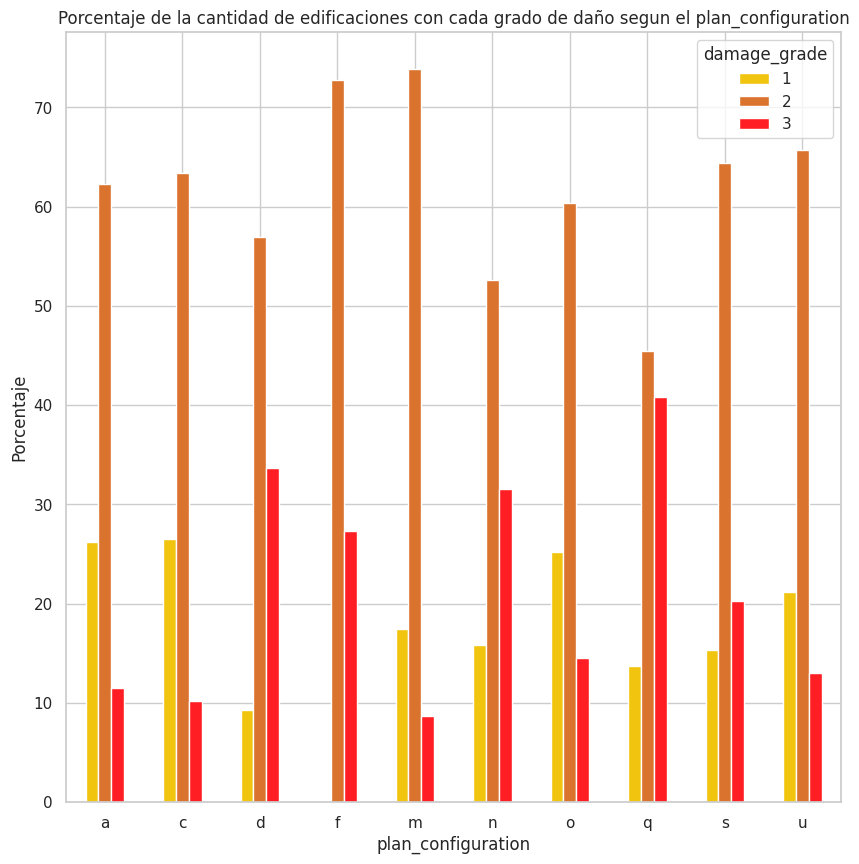

In [10]:
df_plan_and_damage_with_percentage_bar.plot(kind='bar',figsize=(10,10), rot=0, \
 title='Porcentaje de la cantidad de edificaciones con cada grado de daño segun el plan_configuration',
 color={ 1: '#f1c40f', 2: '#da732e', 3: '#ff1e23' })
ax=plt.gca()
ax.set_xlabel('plan_configuration')
ax.set_ylabel('Porcentaje');

Con estos resultados podríamos decir que las categorías a, c, m y o fueron menos perjudicadas. En terminos relativos han sufrido menor cantidad de daño que las demás categorías, las cuales, tienen cierta coherencia con el resto de los datos. 

Podríamos analizar ahora, que es lo que pasará con esas categorías contemplando otras variables como la edad o la cantidad de pisos.

__Filtro los datos por plan de configuración a analizar__

In [11]:
loc_configuratoin_filter = ((df_train_values['plan_configuration'] == 'a')\
                    | (df_train_values['plan_configuration'] == 'c')\
                    | (df_train_values['plan_configuration'] == 'm')\
                    | (df_train_values['plan_configuration'] == 'o'))

df_by_plan_segment_filtered = df_train_values.loc[loc_configuratoin_filter, ['building_id', 'age']]
df_by_plan_segment_filtered = df_by_plan_segment_filtered.loc[df_by_plan_segment_filtered['age'] < 100, :]
df_by_plan_segment_filtered

,building_id,age
512,143285,90
615,200363,20
1389,434716,5
1762,708065,10
2331,546507,15
...,...,...
259076,1001943,10
259434,619498,15
259663,778378,20
259783,316990,25


__Calculo los totales de este segmento de edificios por antiguedad de construcción__

In [12]:
total_buildings_by_age = df_by_plan_segment_filtered.groupby('age')\
    .count()\
    .reset_index()\
    .rename(columns = {'building_id': 'total_buildings_by_age'})

__hago el merge__

In [13]:
df_by_plan_segment_merged = total_buildings_by_age\
    .merge(df_by_plan_segment_filtered)\
    .merge(df_train_labels)

__Agrupo y calculo el porcentaje__

In [19]:
df_age_and_damage_with_percentage = df_by_plan_segment_merged\
    .groupby(['age', 'damage_grade', 'total_buildings_by_age'])\
    .count()\
    .reset_index()\
    .rename(columns = { 'building_id': 'total_buildings_by_age_and_damage' })

df_age_and_damage_with_percentage['porcentaje'] = (df_age_and_damage_with_percentage['total_buildings_by_age_and_damage'] * 100) / df_age_and_damage_with_percentage['total_buildings_by_age']

Text(0, 0.5, 'Porcentaje')

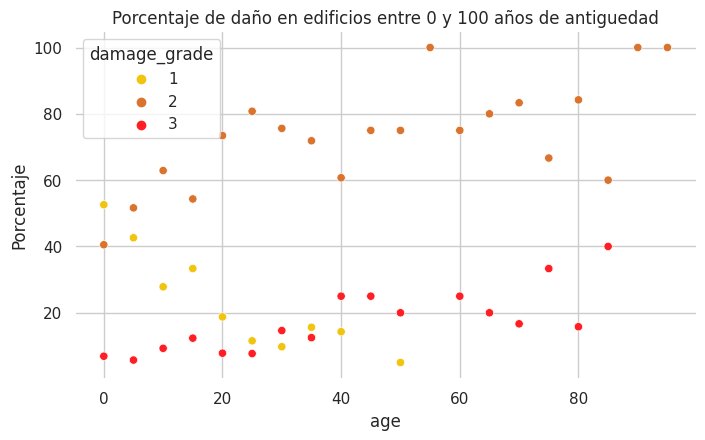

In [18]:
f, ax = plt.subplots(figsize=(8, 4.5))
sns.despine(f, left=True, bottom=True)
damage = [1, 2, 3]
plot = sns.scatterplot(
    x="age",
    y="porcentaje",
    hue="damage_grade",
    palette={ 1: '#f1c40f', 2: '#da732e', 3: '#ff1e23' },
    data=df_age_and_damage_with_percentage,
    ax=ax
)
plt.title('Porcentaje de daño en edificios entre 0 y 100 años de antiguedad')
plt.xlabel('age')
plt.ylabel('Porcentaje')

Es interesante ver como los edificios de las categorías mencionadas a medida que pasa el tiempo es mas probable que sufran daños mas elevados, lo cual puede tener cierta lógica, pues el paso del tiempo puede ser un factor a tener en cuenta. 

Por otra parte, mientras mas nuevo es el edificio es mas probable que reciba daños menores o de grado 1 y el daño 3 es muy bajo en relación al gráfico que demuestra los daños con el paso del tiempo.